# Prepare audio data for image recognition

The data is pretty good, but there's a few samples that aren't exactly 1 second long and some samples that are either truncated or don't contain very much of the word.

The code in the notebook attempts to filter out the broken audio so that we are only using good audio.

We then generate spectrograms of each word. We mix in background noise with the words to make it a more realistic audio sample.

## Download data set
Download from: https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz - approx 2.3 GB

And then run
```
tar -xzf data_speech_commands_v0.02.tar.gz -C speech_data
```

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
f = open('generate_data.txt', 'a')

def write(txt):
    f.write(f'{txt}\n')

In [4]:
SPEECH_DATA='C:/Gilad/University/semester_4/IoT_project/speech_commands_v0.02'

In [5]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [6]:
# list of folders we want to process in the speech_data folder
from tensorflow.python.ops import gen_audio_ops as audio_ops
words = [
    'backward',
    'bed',
    'bird',
    'cat',
    'dog',
    'down',
    'eight',
    'five',
    'follow',
    'forward',
    'four',
    'go',
    'happy',
    'house',
    'learn',
    'left',
    'marvin',
    'nine',
    'no',
    'off',
    'on',
    'one',
    'right',
    'seven',
    'sheila',
    'six',
    'stop',
    'three',
    'tree',
    'two',
    'up',
    'visual',
    'wow',
    'yes',
    'zero',
    '_background',
]

In [7]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')

# get the location of the voice
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()


def is_valid_file(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # is there any voice in the audio?
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [8]:
def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [9]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # add some random background noise
    background_volume = np.random.uniform(0, 0.1)
    # get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # mix the audio with the scaled background
    audio = audio + background_volume * background
    # get the spectrogram
    return get_spectrogram(audio)

In [10]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [11]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, repeat=1):
    # the index of the word word we are processing
    label = words.index(word)
    # get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samples
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# process all the words and all the files
for word in tqdm(words, desc="Processing words"):
    if '_' not in word:
        # add more examples of go to balance our training set
        repeat = 1
        if word == 'go': repeat = 45
        if word == 'car': repeat = 10
        process_word(word, repeat=repeat)
    
print(len(train), len(test), len(validate))
write(f'Process all word: train: {len(train)}, test: {len(test)}, validate: {len(validate)}')

Processing words:   0%|          | 0/36 [00:00<?, ?it/s]

Checking:   0%|          | 0/1664 [00:00<?, ?it/s]

backward (0):   0%|          | 0/1225 [00:00<?, ?it/s]

backward (0):   0%|          | 0/153 [00:00<?, ?it/s]

backward (0):   0%|          | 0/154 [00:00<?, ?it/s]

Checking:   0%|          | 0/2014 [00:00<?, ?it/s]

bed (1):   0%|          | 0/998 [00:00<?, ?it/s]

bed (1):   0%|          | 0/124 [00:00<?, ?it/s]

bed (1):   0%|          | 0/126 [00:00<?, ?it/s]

Checking:   0%|          | 0/2064 [00:00<?, ?it/s]

bird (2):   0%|          | 0/1293 [00:00<?, ?it/s]

bird (2):   0%|          | 0/161 [00:00<?, ?it/s]

bird (2):   0%|          | 0/163 [00:00<?, ?it/s]

Checking:   0%|          | 0/2031 [00:00<?, ?it/s]

cat (3):   0%|          | 0/921 [00:00<?, ?it/s]

cat (3):   0%|          | 0/115 [00:00<?, ?it/s]

cat (3):   0%|          | 0/116 [00:00<?, ?it/s]

Checking:   0%|          | 0/2128 [00:00<?, ?it/s]

dog (4):   0%|          | 0/1306 [00:00<?, ?it/s]

dog (4):   0%|          | 0/163 [00:00<?, ?it/s]

dog (4):   0%|          | 0/164 [00:00<?, ?it/s]

Checking:   0%|          | 0/3917 [00:00<?, ?it/s]

down (5):   0%|          | 0/2623 [00:00<?, ?it/s]

down (5):   0%|          | 0/327 [00:00<?, ?it/s]

down (5):   0%|          | 0/329 [00:00<?, ?it/s]

Checking:   0%|          | 0/3787 [00:00<?, ?it/s]

eight (6):   0%|          | 0/1858 [00:00<?, ?it/s]

eight (6):   0%|          | 0/232 [00:00<?, ?it/s]

eight (6):   0%|          | 0/233 [00:00<?, ?it/s]

Checking:   0%|          | 0/4052 [00:00<?, ?it/s]

five (7):   0%|          | 0/2376 [00:00<?, ?it/s]

five (7):   0%|          | 0/297 [00:00<?, ?it/s]

five (7):   0%|          | 0/297 [00:00<?, ?it/s]

Checking:   0%|          | 0/1579 [00:00<?, ?it/s]

follow (8):   0%|          | 0/1063 [00:00<?, ?it/s]

follow (8):   0%|          | 0/132 [00:00<?, ?it/s]

follow (8):   0%|          | 0/134 [00:00<?, ?it/s]

Checking:   0%|          | 0/1557 [00:00<?, ?it/s]

forward (9):   0%|          | 0/1113 [00:00<?, ?it/s]

forward (9):   0%|          | 0/139 [00:00<?, ?it/s]

forward (9):   0%|          | 0/140 [00:00<?, ?it/s]

Checking:   0%|          | 0/3728 [00:00<?, ?it/s]

four (10):   0%|          | 0/2250 [00:00<?, ?it/s]

four (10):   0%|          | 0/281 [00:00<?, ?it/s]

four (10):   0%|          | 0/282 [00:00<?, ?it/s]

Checking:   0%|          | 0/3880 [00:00<?, ?it/s]

go (11):   0%|          | 0/97065 [00:00<?, ?it/s]

go (11):   0%|          | 0/12105 [00:00<?, ?it/s]

go (11):   0%|          | 0/12195 [00:00<?, ?it/s]

Checking:   0%|          | 0/2054 [00:00<?, ?it/s]

happy (12):   0%|          | 0/1285 [00:00<?, ?it/s]

happy (12):   0%|          | 0/160 [00:00<?, ?it/s]

happy (12):   0%|          | 0/162 [00:00<?, ?it/s]

Checking:   0%|          | 0/2113 [00:00<?, ?it/s]

house (13):   0%|          | 0/1132 [00:00<?, ?it/s]

house (13):   0%|          | 0/141 [00:00<?, ?it/s]

house (13):   0%|          | 0/142 [00:00<?, ?it/s]

Checking:   0%|          | 0/1575 [00:00<?, ?it/s]

learn (14):   0%|          | 0/1096 [00:00<?, ?it/s]

learn (14):   0%|          | 0/137 [00:00<?, ?it/s]

learn (14):   0%|          | 0/137 [00:00<?, ?it/s]

Checking:   0%|          | 0/3801 [00:00<?, ?it/s]

left (15):   0%|          | 0/1876 [00:00<?, ?it/s]

left (15):   0%|          | 0/234 [00:00<?, ?it/s]

left (15):   0%|          | 0/235 [00:00<?, ?it/s]

Checking:   0%|          | 0/2100 [00:00<?, ?it/s]

marvin (16):   0%|          | 0/1438 [00:00<?, ?it/s]

marvin (16):   0%|          | 0/179 [00:00<?, ?it/s]

marvin (16):   0%|          | 0/181 [00:00<?, ?it/s]

Checking:   0%|          | 0/3934 [00:00<?, ?it/s]

nine (17):   0%|          | 0/2758 [00:00<?, ?it/s]

nine (17):   0%|          | 0/344 [00:00<?, ?it/s]

nine (17):   0%|          | 0/346 [00:00<?, ?it/s]

Checking:   0%|          | 0/3941 [00:00<?, ?it/s]

no (18):   0%|          | 0/2464 [00:00<?, ?it/s]

no (18):   0%|          | 0/308 [00:00<?, ?it/s]

no (18):   0%|          | 0/309 [00:00<?, ?it/s]

Checking:   0%|          | 0/3745 [00:00<?, ?it/s]

off (19):   0%|          | 0/1188 [00:00<?, ?it/s]

off (19):   0%|          | 0/148 [00:00<?, ?it/s]

off (19):   0%|          | 0/150 [00:00<?, ?it/s]

Checking:   0%|          | 0/3845 [00:00<?, ?it/s]

on (20):   0%|          | 0/2390 [00:00<?, ?it/s]

on (20):   0%|          | 0/298 [00:00<?, ?it/s]

on (20):   0%|          | 0/300 [00:00<?, ?it/s]

Checking:   0%|          | 0/3890 [00:00<?, ?it/s]

one (21):   0%|          | 0/2324 [00:00<?, ?it/s]

one (21):   0%|          | 0/290 [00:00<?, ?it/s]

one (21):   0%|          | 0/292 [00:00<?, ?it/s]

Checking:   0%|          | 0/3778 [00:00<?, ?it/s]

right (22):   0%|          | 0/2111 [00:00<?, ?it/s]

right (22):   0%|          | 0/263 [00:00<?, ?it/s]

right (22):   0%|          | 0/265 [00:00<?, ?it/s]

Checking:   0%|          | 0/3998 [00:00<?, ?it/s]

seven (23):   0%|          | 0/2753 [00:00<?, ?it/s]

seven (23):   0%|          | 0/344 [00:00<?, ?it/s]

seven (23):   0%|          | 0/345 [00:00<?, ?it/s]

Checking:   0%|          | 0/2022 [00:00<?, ?it/s]

sheila (24):   0%|          | 0/1384 [00:00<?, ?it/s]

sheila (24):   0%|          | 0/173 [00:00<?, ?it/s]

sheila (24):   0%|          | 0/173 [00:00<?, ?it/s]

Checking:   0%|          | 0/3860 [00:00<?, ?it/s]

six (25):   0%|          | 0/2321 [00:00<?, ?it/s]

six (25):   0%|          | 0/290 [00:00<?, ?it/s]

six (25):   0%|          | 0/291 [00:00<?, ?it/s]

Checking:   0%|          | 0/3872 [00:00<?, ?it/s]

stop (26):   0%|          | 0/2001 [00:00<?, ?it/s]

stop (26):   0%|          | 0/250 [00:00<?, ?it/s]

stop (26):   0%|          | 0/251 [00:00<?, ?it/s]

Checking:   0%|          | 0/3727 [00:00<?, ?it/s]

three (27):   0%|          | 0/2276 [00:00<?, ?it/s]

three (27):   0%|          | 0/284 [00:00<?, ?it/s]

three (27):   0%|          | 0/286 [00:00<?, ?it/s]

Checking:   0%|          | 0/1759 [00:00<?, ?it/s]

tree (28):   0%|          | 0/1118 [00:00<?, ?it/s]

tree (28):   0%|          | 0/139 [00:00<?, ?it/s]

tree (28):   0%|          | 0/141 [00:00<?, ?it/s]

Checking:   0%|          | 0/3880 [00:00<?, ?it/s]

two (29):   0%|          | 0/2164 [00:00<?, ?it/s]

two (29):   0%|          | 0/270 [00:00<?, ?it/s]

two (29):   0%|          | 0/271 [00:00<?, ?it/s]

Checking:   0%|          | 0/3723 [00:00<?, ?it/s]

up (30):   0%|          | 0/790 [00:00<?, ?it/s]

up (30):   0%|          | 0/98 [00:00<?, ?it/s]

up (30):   0%|          | 0/100 [00:00<?, ?it/s]

Checking:   0%|          | 0/1592 [00:00<?, ?it/s]

visual (31):   0%|          | 0/1149 [00:00<?, ?it/s]

visual (31):   0%|          | 0/143 [00:00<?, ?it/s]

visual (31):   0%|          | 0/145 [00:00<?, ?it/s]

Checking:   0%|          | 0/2123 [00:00<?, ?it/s]

wow (32):   0%|          | 0/1356 [00:00<?, ?it/s]

wow (32):   0%|          | 0/169 [00:00<?, ?it/s]

wow (32):   0%|          | 0/170 [00:00<?, ?it/s]

Checking:   0%|          | 0/4044 [00:00<?, ?it/s]

yes (33):   0%|          | 0/2364 [00:00<?, ?it/s]

yes (33):   0%|          | 0/295 [00:00<?, ?it/s]

yes (33):   0%|          | 0/297 [00:00<?, ?it/s]

Checking:   0%|          | 0/4052 [00:00<?, ?it/s]

zero (34):   0%|          | 0/2957 [00:00<?, ?it/s]

zero (34):   0%|          | 0/369 [00:00<?, ?it/s]

zero (34):   0%|          | 0/371 [00:00<?, ?it/s]

156786 19693 19555


In [12]:
# process the background noise files
def process_background(file_name, label):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 8000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    # simulate random utterances
    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        # create a pseudo bit of voice
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        # amplify the voice section
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        # get the spectrogram
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))
        
    
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, words.index("_background"))
    
print(len(train), len(test), len(validate))
write(f'Process background: train: {len(train)}, test: {len(test)}, validate: {len(validate)}')


Processing Background Noise:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_background_noise_\doing_the_dishes.wav:   0%…

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_background_noise_\dude_miaowing.wav:   0%|  …

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_background_noise_\exercise_bike.wav:   0%|  …

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_background_noise_\pink_noise.wav:   0%|     …

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_background_noise_\running_tap.wav:   0%|    …

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_background_noise_\white_noise.wav:   0%|    …

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

162214 20378 20231


In [21]:
def process_problem_noise(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 400), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noise(file_name, words.index("_background"))

Processing problem noise:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_problem_noise_\noise.wav:   0%|          | 0…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_problem_noise_\noise2.wav:   0%|          | …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_problem_noise_\noise3.wav:   0%|          | …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_problem_noise_\noise4.wav:   0%|          | …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_problem_noise_\noise5.wav:   0%|          | …

In [22]:
def process_go_sounds(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 4000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        section = section - np.mean(section)
        section = section / np.max(np.abs(section))
        # add some random background noise
        background_volume = np.random.uniform(0, 0.1)
        # get the background noise files
        background_files = get_files('_background_noise_')
        background_file = np.random.choice(background_files)
        background_tensor = tfio.audio.AudioIOTensor(background_file)
        background_start = np.random.randint(0, len(background_tensor) - 16000)
        # normalise the background noise
        background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
        background = background - np.mean(background)
        background = background / np.max(np.abs(background))
        # mix the audio with the scaled background
        section = section + background_volume * background
        # get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_go_sounds"), desc="Processing problem noise"):
    process_go_sounds(file_name, words.index("_background"))

Processing problem noise:   0%|          | 0/1023 [00:00<?, ?it/s]

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_100_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_101_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_102_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_103_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_104_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_105_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_106_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_107_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_108_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_109_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_10_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_110_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_111_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_112_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_113_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_114_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_115_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_116_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_117_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_118_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_119_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_11_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_120_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_121_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_122_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_123_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_124_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_125_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_126_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_127_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_128_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_129_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_12_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_130_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_131_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_132_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_133_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_134_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_135_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_136_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_137_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_138_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_139_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_13_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_140_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_141_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_142_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_143_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_144_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_145_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_146_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_147_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_148_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_149_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_14_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_150_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_151_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_152_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_153_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_154_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_155_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_156_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_157_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_158_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_159_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_15_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_160_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_161_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_162_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_163_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_164_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_165_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_166_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_167_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_168_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_169_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_16_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_170_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_171_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_172_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_173_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_174_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_175_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_176_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_177_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_178_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_179_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_17_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_180_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_181_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_182_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_183_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_184_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_185_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_186_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_187_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_188_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_189_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_18_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_190_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_191_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_192_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_193_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_194_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_195_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_196_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_197_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_198_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_199_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_19_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_1_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_200_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_201_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_202_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_203_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_204_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_205_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_206_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_207_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_208_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_209_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_20_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_210_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_211_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_212_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_213_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_214_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_215_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_216_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_217_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_218_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_219_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_21_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_220_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_221_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_222_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_223_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_224_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_225_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_226_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_227_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_228_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_229_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_22_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_230_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_231_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_232_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_233_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_234_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_235_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_236_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_237_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_238_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_239_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_23_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_240_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_241_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_242_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_243_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_244_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_245_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_246_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_247_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_248_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_249_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_24_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_250_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_251_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_252_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_253_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_254_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_255_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_256_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_257_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_258_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_259_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_25_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_260_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_261_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_262_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_263_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_264_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_265_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_266_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_267_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_268_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_269_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_26_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_270_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_271_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_272_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_273_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_274_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_275_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_276_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_277_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_278_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_279_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_27_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_280_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_281_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_282_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_283_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_284_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_285_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_286_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_287_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_288_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_289_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_28_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_290_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_291_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_292_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_293_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_294_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_295_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_296_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_297_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_298_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_299_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_29_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_2_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_300_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_301_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_302_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_303_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_304_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_305_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_306_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_307_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_308_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_309_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_30_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_310_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_311_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_312_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_313_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_314_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_315_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_316_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_317_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_318_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_319_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_31_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_320_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_321_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_322_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_323_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_324_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_325_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_326_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_327_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_328_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_329_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_32_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_330_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_331_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_332_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_333_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_334_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_335_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_336_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_337_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_338_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_339_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_33_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_340_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_341_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_342_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_343_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_344_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_345_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_346_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_347_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_348_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_349_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_34_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_350_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_351_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_352_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_353_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_354_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_355_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_356_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_357_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_358_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_359_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_35_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_360_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_361_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_362_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_363_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_364_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_365_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_366_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_367_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_368_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_369_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_36_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_370_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_371_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_372_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_373_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_374_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_375_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_376_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_377_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_378_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_379_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_37_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_380_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_381_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_382_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_383_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_384_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_385_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_386_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_387_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_388_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_389_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_38_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_390_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_391_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_392_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_393_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_394_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_395_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_396_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_397_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_398_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_399_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_39_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_3_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_400_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_401_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_402_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_403_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_404_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_405_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_406_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_407_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_408_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_409_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_40_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_410_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_411_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_412_F.wav:   0%|       …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_41_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_42_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_43_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_44_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_45_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_46_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_47_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_48_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_49_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_4_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_50_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_51_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_52_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_53_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_54_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_55_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_56_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_57_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_58_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_59_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_5_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_60_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_61_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_62_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_63_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_64_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_65_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_66_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_67_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_68_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_69_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_6_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_70_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_71_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_72_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_73_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_74_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_75_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_76_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_77_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_78_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_79_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_7_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_80_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_81_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_82_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_83_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_84_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_85_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_86_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_87_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_88_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_89_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_8_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_90_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_91_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_92_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_93_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_94_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_95_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_96_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_97_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_98_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_99_F.wav:   0%|        …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\contain_go_9_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_100_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_101_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_102_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_103_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_104_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_105_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_106_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_107_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_108_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_109_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_10_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_110_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_111_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_112_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_113_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_114_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_115_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_116_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_117_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_118_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_119_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_11_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_120_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_121_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_122_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_123_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_124_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_125_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_126_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_127_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_128_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_129_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_12_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_130_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_131_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_132_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_133_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_134_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_135_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_136_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_137_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_138_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_139_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_13_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_140_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_141_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_142_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_143_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_144_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_145_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_146_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_147_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_148_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_149_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_14_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_150_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_151_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_152_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_153_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_154_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_155_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_156_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_157_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_158_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_159_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_15_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_160_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_161_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_162_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_163_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_164_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_165_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_166_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_167_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_168_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_169_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_16_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_170_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_171_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_172_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_173_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_174_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_175_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_176_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_177_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_178_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_179_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_17_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_180_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_181_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_182_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_183_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_184_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_185_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_186_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_187_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_188_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_189_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_18_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_190_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_191_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_192_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_193_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_194_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_195_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_196_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_197_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_198_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_199_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_19_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_1_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_200_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_201_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_202_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_203_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_204_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_205_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_206_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_207_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_208_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_209_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_20_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_210_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_211_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_212_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_213_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_214_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_215_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_216_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_217_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_218_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_219_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_21_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_220_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_221_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_222_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_223_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_224_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_225_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_226_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_227_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_228_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_229_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_22_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_230_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_231_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_232_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_233_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_234_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_235_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_236_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_237_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_238_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_239_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_23_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_240_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_241_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_242_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_243_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_244_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_245_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_246_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_247_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_248_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_249_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_24_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_250_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_251_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_252_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_253_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_254_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_255_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_256_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_257_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_258_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_259_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_25_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_260_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_261_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_262_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_263_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_264_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_265_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_266_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_267_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_268_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_269_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_26_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_270_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_271_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_272_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_273_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_274_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_275_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_276_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_277_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_278_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_279_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_27_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_280_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_281_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_282_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_283_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_284_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_285_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_286_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_287_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_288_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_289_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_28_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_290_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_291_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_292_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_293_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_294_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_295_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_296_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_297_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_298_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_299_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_29_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_2_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_300_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_301_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_302_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_303_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_304_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_305_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_306_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_307_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_308_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_309_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_30_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_310_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_311_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_312_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_313_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_314_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_315_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_316_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_317_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_318_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_319_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_31_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_320_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_321_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_322_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_323_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_324_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_325_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_326_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_327_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_328_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_329_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_32_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_330_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_331_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_332_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_333_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_334_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_335_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_336_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_337_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_338_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_339_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_33_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_340_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_341_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_342_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_343_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_344_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_345_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_346_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_347_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_348_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_349_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_34_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_350_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_351_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_352_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_353_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_354_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_355_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_356_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_357_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_358_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_359_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_35_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_360_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_361_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_362_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_363_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_364_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_365_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_366_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_367_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_368_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_369_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_36_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_370_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_371_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_372_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_373_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_374_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_375_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_376_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_377_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_378_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_379_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_37_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_380_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_381_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_382_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_383_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_384_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_385_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_386_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_387_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_388_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_389_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_38_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_390_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_391_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_392_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_393_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_394_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_395_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_396_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_397_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_398_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_399_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_39_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_3_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_400_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_401_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_402_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_403_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_404_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_405_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_406_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_407_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_408_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_409_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_40_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_410_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_411_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_412_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_413_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_414_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_415_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_416_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_417_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_418_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_419_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_41_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_420_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_421_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_422_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_423_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_424_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_425_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_426_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_427_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_428_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_429_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_42_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_430_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_431_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_432_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_433_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_434_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_435_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_436_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_437_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_438_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_439_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_43_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_440_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_441_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_442_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_443_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_444_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_445_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_446_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_447_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_448_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_449_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_44_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_450_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_451_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_452_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_453_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_454_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_455_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_456_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_457_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_458_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_459_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_45_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_460_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_461_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_462_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_463_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_464_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_465_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_466_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_467_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_468_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_469_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_46_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_470_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_471_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_472_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_473_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_474_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_475_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_476_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_477_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_478_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_479_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_47_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_480_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_481_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_482_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_483_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_484_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_485_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_486_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_487_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_488_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_489_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_48_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_490_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_491_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_492_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_493_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_494_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_495_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_496_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_497_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_498_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_499_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_49_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_4_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_500_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_501_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_502_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_503_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_504_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_505_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_506_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_507_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_508_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_509_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_50_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_510_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_511_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_512_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_513_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_514_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_515_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_516_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_517_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_518_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_519_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_51_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_520_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_521_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_522_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_523_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_524_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_525_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_526_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_527_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_528_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_529_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_52_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_530_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_531_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_532_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_533_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_534_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_535_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_536_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_537_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_538_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_539_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_53_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_540_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_541_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_542_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_543_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_544_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_545_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_546_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_547_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_548_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_549_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_54_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_550_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_551_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_552_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_553_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_554_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_555_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_556_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_557_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_558_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_559_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_55_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_560_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_561_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_562_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_563_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_564_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_565_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_566_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_567_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_568_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_569_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_56_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_570_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_571_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_572_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_573_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_574_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_575_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_576_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_577_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_578_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_579_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_57_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_580_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_581_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_582_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_583_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_584_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_585_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_586_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_587_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_588_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_589_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_58_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_590_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_591_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_592_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_593_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_594_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_595_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_596_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_597_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_598_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_599_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_59_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_5_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_600_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_601_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_602_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_603_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_604_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_605_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_606_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_607_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_608_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_609_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_60_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_610_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_611_F.wav:   0%|         …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_61_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_62_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_63_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_64_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_65_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_66_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_67_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_68_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_69_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_6_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_70_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_71_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_72_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_73_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_74_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_75_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_76_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_77_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_78_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_79_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_7_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_80_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_81_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_82_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_83_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_84_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_85_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_86_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_87_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_88_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_89_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_8_F.wav:   0%|          |…

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_90_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_91_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_92_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_93_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_94_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_95_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_96_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_97_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_98_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_99_F.wav:   0%|          …

C:\Gilad\University\semester_4\IoT_project\speech_commands_v0.02\_go_sounds\start_go_9_F.wav:   0%|          |…

In [23]:
print(len(train), len(test), len(validate))
write(f'Process problem noise: train: {len(train)}, test: {len(test)}, validate: {len(validate)}')


173791 22626 21212


In [24]:
# randomise the training samples
np.random.shuffle(train)

In [25]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [26]:
# save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
write(f'Saved training data\n')
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
write(f'Saved validation data\n')
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")
write(f'Saved test data\n')

Saved training data
Saved validation data
Saved test data


In [27]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [28]:
def plot_images2(images_arr, imageWidth, imageHeight, name):
    fig, axes = plt.subplots(5, 5, figsize=(10, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(f'{name}.txt')
    plt.show()
    

ValueError: Format 'txt' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

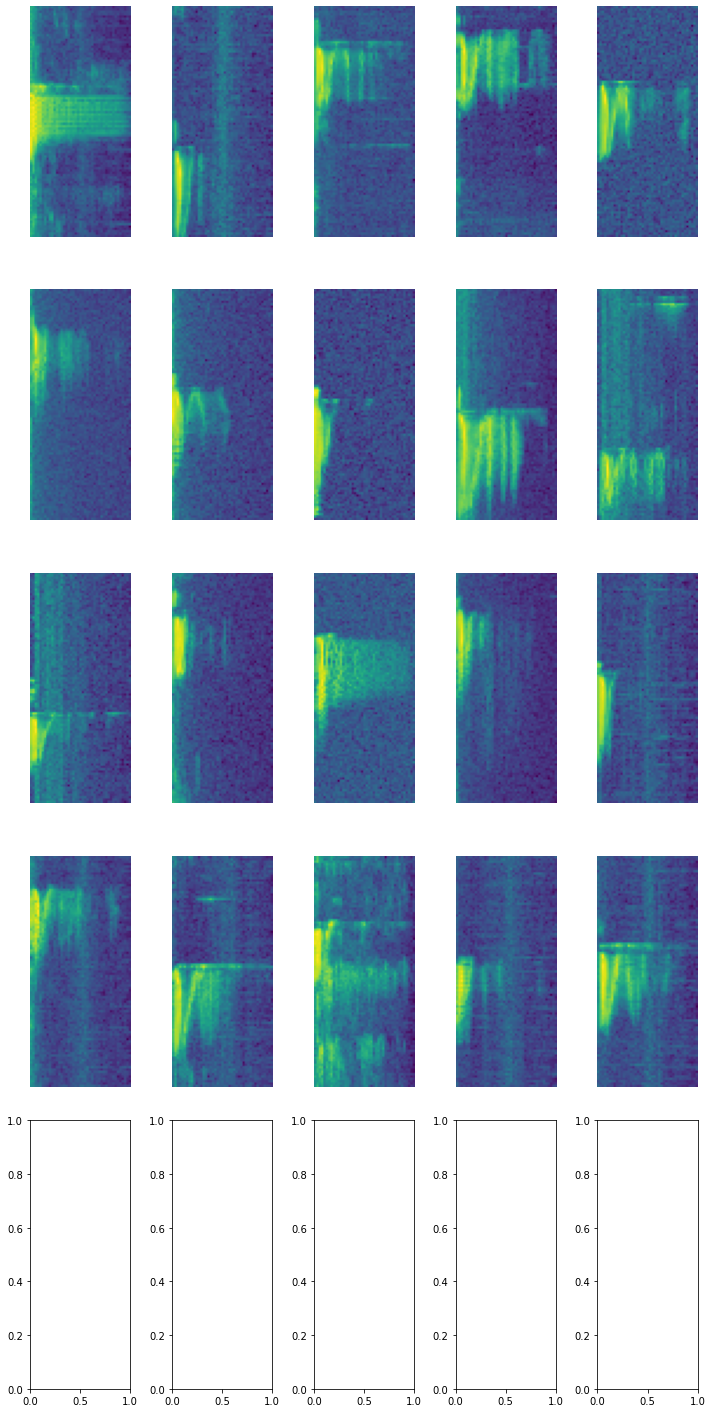

In [29]:
word_index = words.index("go")

X_go = np.array(X_train)[np.array(Y_train) == word_index]
Y_go = np.array(Y_train)[np.array(Y_train) == word_index]
plot_images2(X_go[:20], IMG_WIDTH, IMG_HEIGHT, 'go')
print(Y_go[:20])

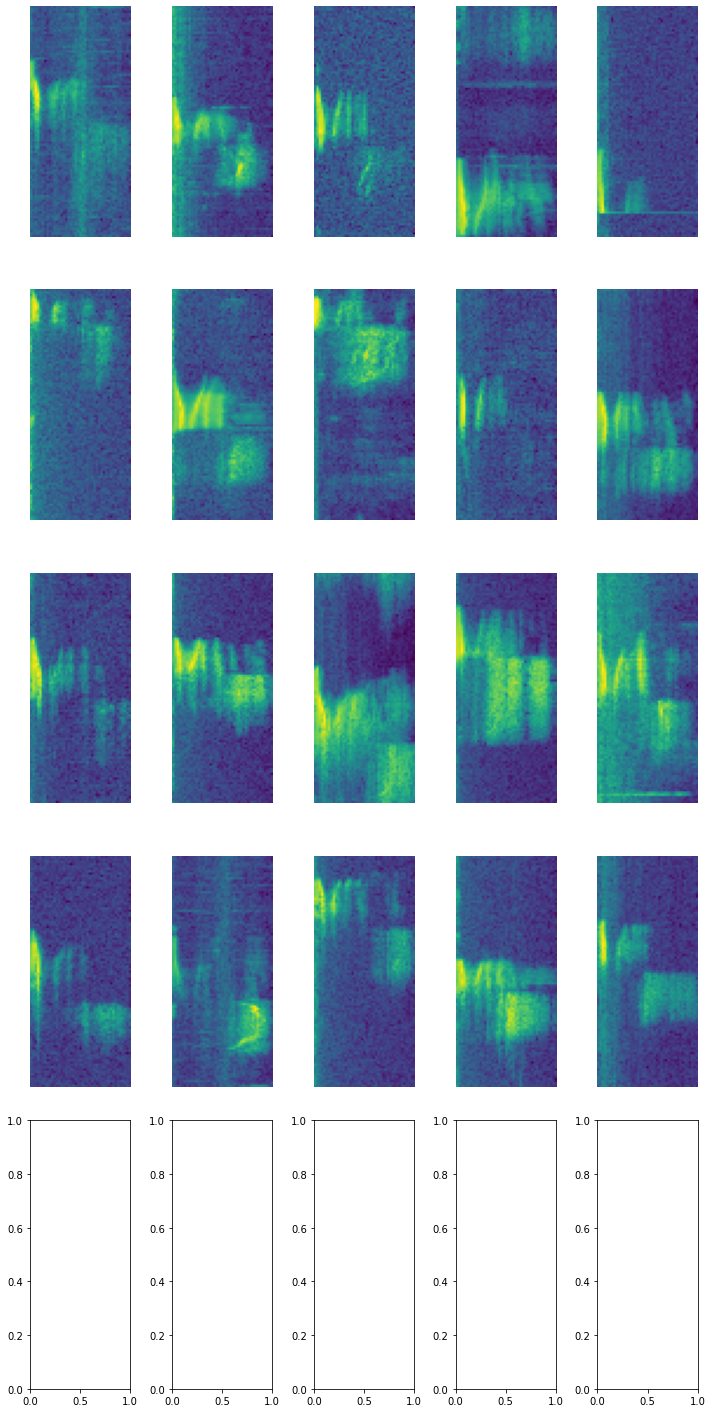

[33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33]


In [ ]:
word_index = words.index("yes")

X_yes = np.array(X_train)[np.array(Y_train) == word_index]
Y_yes = np.array(Y_train)[np.array(Y_train) == word_index]
plot_images2(X_yes[:20], IMG_WIDTH, IMG_HEIGHT, 'yes')
print(Y_yes[:20])